In [223]:
# FILES NEEDED - available in bcdist.tar.gz
# - headerlist.txt
# - drop.txt
# - correlatesofstatepolicyprojectv1_10.csv

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from IPython.core.display import display, HTML
print "... python ready"

# 'headerlist.txt' lists all columns
# 'drop.txt' indicates which ones are being used and whether they're numeric or binary

# load the headerlist and drop list
f = open('headerlist.txt', 'r')
headerlist = f.read().rstrip('\n').split(',')
droplist = pd.read_csv('drop.txt', dtype='unicode', names=['name', 'action', 'type'])
keeplist = droplist[droplist.action == 'keep']
droplist = droplist[droplist.action == 'drop']['name']#.tolist()

# load the data itself
data = pd.read_csv('correlatesofstatepolicyprojectv1_10.csv', dtype='unicode', names=headerlist, encoding = 'utf8')

# purge things that aren't needed
data.drop(0, inplace=True)   # drop header row
data = data[data.st != 'DC'] # drop DC, because so much of it is missing
data = data[data.st != 'NE'] # drop Nebraska - has no state house data
for d in droplist: data = data.drop(d, 1)

print "... data ready"

def policy_table(policy, action):
    data[policy] = data[policy].astype('float')
    cs = data[['year', 'st', policy]]
    if action == 'adoption':
        policy_table = cs[cs[policy] >= 1].groupby('st').nth(0).head(1000).sort_values('year')
    elif action == 'repeal':
        policy_table = cs[cs[policy] >= 1].groupby('st').last().head(1000).sort_values('year')
    elif action == 'block':
        policy_table = cs[cs[policy] >= 1].groupby('st').head(1000).sort_values('year')
    policy_table.reset_index(inplace=True)
    return policy_table

def numeric_pivot(c, action):
    table = data[['st', 'year', c]]
    if action == 'pivot':
        ptable = table.pivot(index='year', columns='st', values=c)
        ptable = ptable.astype('float')
        ptable['national_average'] = ptable.mean(axis=1)
    elif action == 'datacheck':
        table = table
        table.is_copy = False
        table[c] = table[c].astype('float')
        s = table[c]
        ptable = table
    ptable=ptable.dropna(how='any',axis=0)
    return ptable

def browntext(text):
    display (HTML("<font color=\"brown\">"+text+"</fond>"))
    
print "... subs ready"

... python ready
... data ready
... subs ready


In [224]:
print "\n                   ***** WRANGLING and CLEANING UP ******\n"

print "|   The MSU Correlates of State Policy dataset contains state level political "
print "|   and demographic data.\n"
print "|   The data consists of numeric columns such as population, income and "
print "|   the political makeup of state houses as well as policy columns indicating "
print "|   things like whether and when women were allowed to serve on juries.\n"

print "|   Together, there are ~ 900 columns, roughly half of which I chose to "
print "|   drop at the outset for being redundant, for not having enough data or for "
print "|   some other reason.  For similar reasons, the choice was also made to drop"
print "|   DC and Nebraska.  The objective of this notebook is to examine the "
print "|   remaining columns and give thought to what procedures may be needed to"
print "|   to render them easy to work wtih.\n"

print "|   The data is presented with a set of rows for each year, for each state.  That "
print "|   gives us (50 states) * (117 years) = 5850 rows\n"

policy_actions = keeplist[keeplist.type == 'bin']
num_bin_policies = len(policy_actions)

numeric_indicators = keeplist[keeplist.type == 'num']
num_num = len(numeric_indicators)

print "|   The data has the structure of the example just below, though "
print "|   this is a subset:\n"

data[(data.year == '2000') | (data.year == '2001')]\
    [['st', 'year','hs_rep_in_sess', 'hs_dem_in_sess', 'incshare_top10', \
      'incshare_top001', 'poptotal',\
      'childseat', 'schoolchoi', 'minwage']].head(6)


                   ***** WRANGLING and CLEANING UP ******

|   The MSU Correlates of State Policy dataset contains state level political 
|   and demographic data.

|   The data consists of numeric columns such as population, income and 
|   the political makeup of state houses as well as policy columns indicating 
|   things like whether and when women were allowed to serve on juries.

|   Together, there are ~ 900 columns, roughly half of which I chose to 
|   drop at the outset for being redundant, for not having enough data or for 
|   some other reason.  For similar reasons, the choice was also made to drop
|   DC and Nebraska.  The objective of this notebook is to examine the 
|   remaining columns and give thought to what procedures may be needed to
|   to render them easy to work wtih.

|   The data is presented with a set of rows for each year, for each state.  That 
|   gives us (50 states) * (117 years) = 5850 rows

|   The data has the structure of the example just below, 

,st,year,hs_rep_in_sess,hs_dem_in_sess,incshare_top10,incshare_top001,poptotal,childseat,schoolchoi,minwage
101,AK,2000,26,14,36.19701,1.7588772,627428,1,0,0
102,AK,2001,27,13,34.525017,1.0444483,633160,1,0,0
218,AL,2000,36,69,42.204464,2.5108385,4500000,1,1,0
219,AL,2001,36,67,41.291435,1.9679824,4500000,1,1,0
335,AR,2000,23,74,40.796696,3.1854286,2700000,1,1,1
336,AR,2001,30,70,40.077991,2.6903636,2700000,1,1,1



|  Just to get a rough visual sense of what's in the policy tables, below 
|  are the first 36 of them. The dots below mostly represent the 1s (ones) in the data 
|  and each plot column represents a state.  Thus, if there's a dot, it means that that 
|  policy is implemented in that state in that year.

|  Just a few things to note.  Not all data columns are presented in the same way. 
|  While the general pattern is for the data to indicate the adoption sequence of 
|  policies, there are cases where the opposite is the case.  

|  For example, in the column "gayrights_ban_sodomy" (4th from the left, top row),
|  the data gives the impression that all states adopted sodomy bans in 1962.  In 
|  fact, those sodomy bans had been in place long before that.  In this case, the 
|  data begins in 1962 in order to show the sequence of repeals, which takes place 
|  after that date.

|  In another example, the column "w_guncontrol_bc_privatesales", which indicates
|  whether states require 

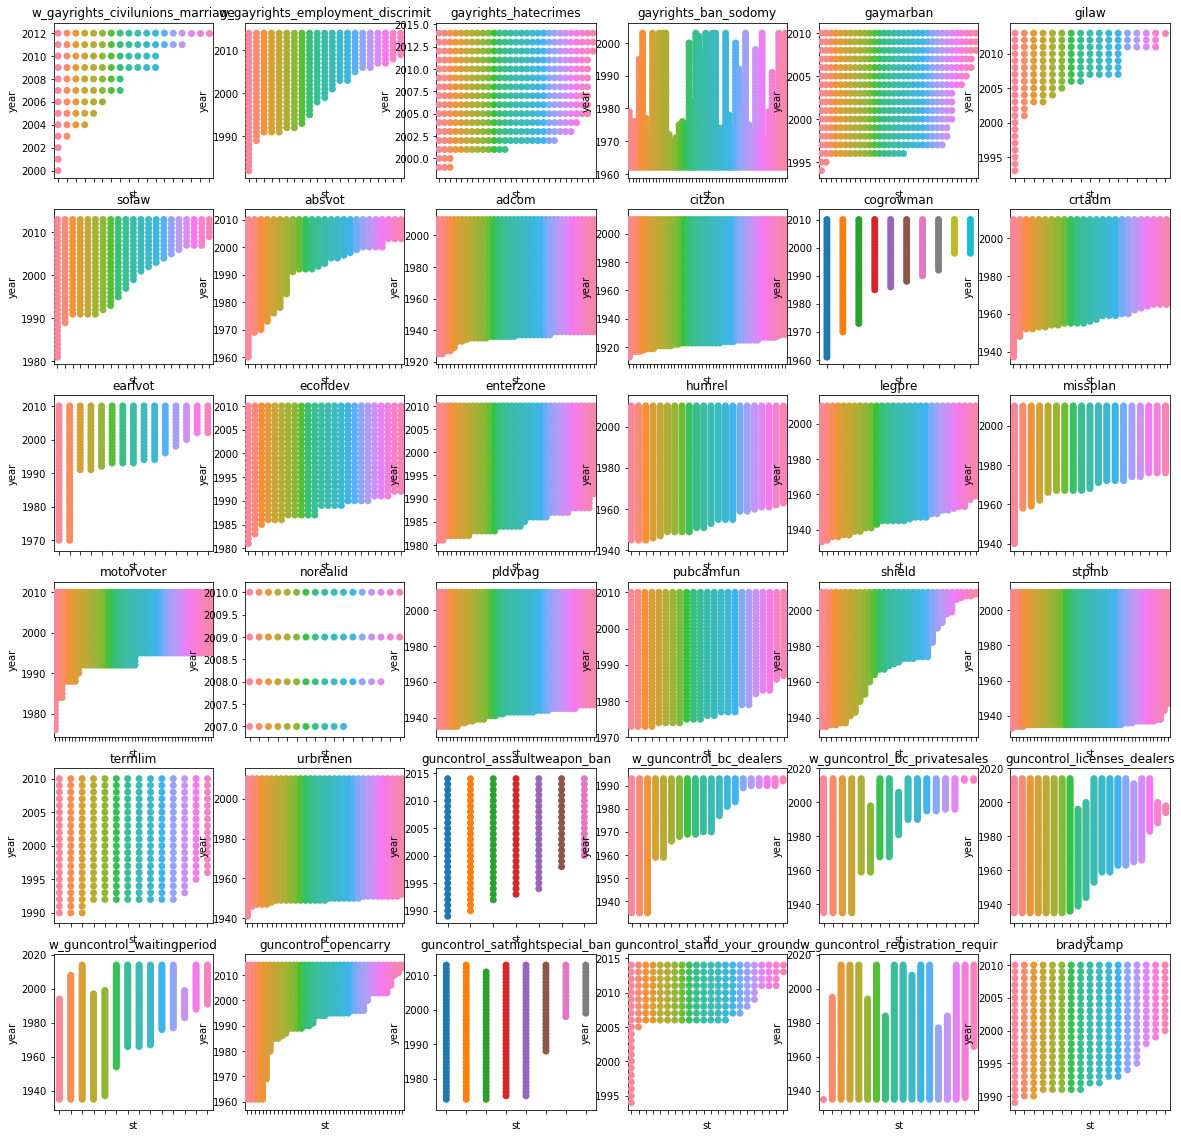

In [225]:
print "\n|  Just to get a rough visual sense of what's in the policy tables, below "
print "|  are the first 36 of them. The dots below mostly represent the 1s (ones) in the data "
print "|  and each plot column represents a state.  Thus, if there's a dot, it means that that "
print "|  policy is implemented in that state in that year.\n"
print "|  Just a few things to note.  Not all data columns are presented in the same way. "
print "|  While the general pattern is for the data to indicate the adoption sequence of "
print "|  policies, there are cases where the opposite is the case.  \n"
print "|  For example, in the column \"gayrights_ban_sodomy\" (4th from the left, top row),"
print "|  the data gives the impression that all states adopted sodomy bans in 1962.  In "
print "|  fact, those sodomy bans had been in place long before that.  In this case, the "
print "|  data begins in 1962 in order to show the sequence of repeals, which takes place "
print "|  after that date.\n"
print "|  In another example, the column \"w_guncontrol_bc_privatesales\", which indicates"
print "|  whether states require background checks for private gun sales, actually records"
print "|  three distinct conditions: 0-no | 1-yes for handguns | 2-yes for rifles.\n"
print "|  Further, in many cases the data abruptly ends (often in 2010).  This does not "
print "|  mean that the states in question suddenly dropped these policies, only that no "
print "|  further events were noted.\n"
print "|  Thus, aggregate summaries of these columns can mislead. The good news is that "
print "|  gaps in the data do not generally appear.  Only one column had a gap that was"
print "|  surrounded by data in other years, making it amenable to a forward fill. That "
print "|  will be addressed below.\n"

#len(policy_actions)/8 = 32
fig, axs = plt.subplots(6,6, figsize=(20,20))
rw = 0
cl = 0
for pa in policy_actions.name[80:116]:
    table = policy_table(pa, 'block')
    sns.stripplot(x='st', y='year', size=7, data=table, ax = axs[rw][cl])
    axs[rw][cl].set_title(pa)
    axs[rw][cl].set(xticklabels=[])
    cl = cl + 1
    if cl > 5:
        cl = 0
        rw = rw + 1


|  The numeric columns also have to be considered individually, as their 
|  presentation varies.  For example, legislative expenditures are only 
|  given in odd years.  The column "Speaker Power" only gives data in odd 
|  years, except in four states where it gives data in all years.  Most of the 
|  columns that need attention are below.

|  In a number of cases, particularly the population columns, the divorce 
|  rate and unemployment, a limited fill strategy is reasonable and will be 
|  implemented in the next section.



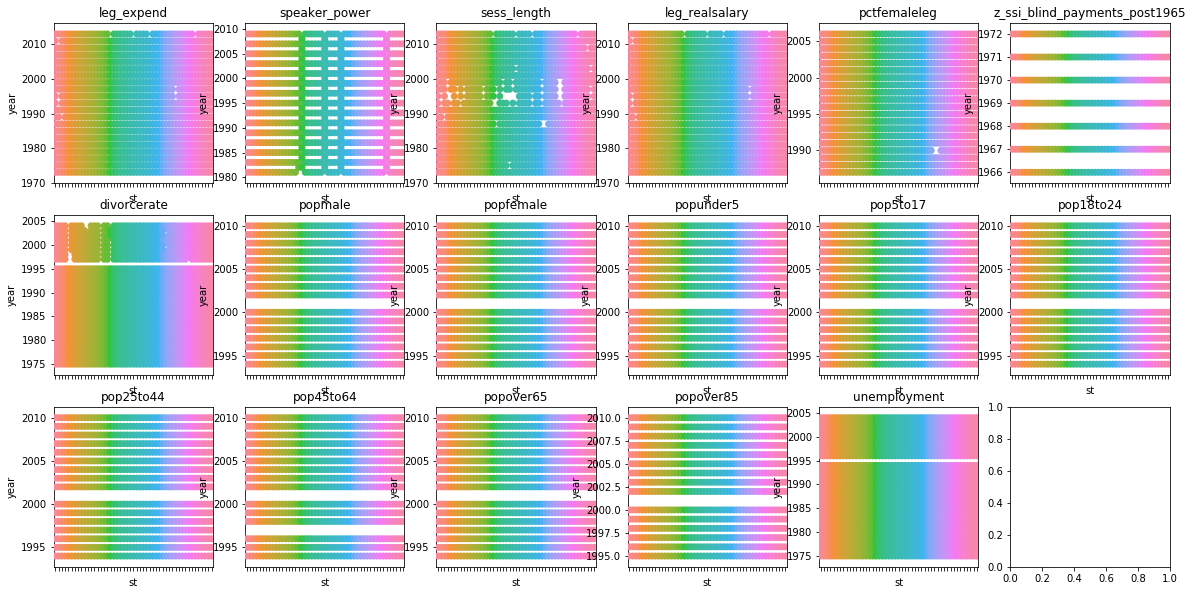

In [226]:
print "\n|  The numeric columns also have to be considered individually, as their "
print "|  presentation varies.  For example, legislative expenditures are only "
print "|  given in odd years.  The column \"Speaker Power\" only gives data in odd "
print "|  years, except in four states where it gives data in all years.  Most of the "
print "|  columns that need attention are below.\n"
print "|  In a number of cases, particularly the population columns, the divorce "
print "|  rate and unemployment, a limited fill strategy is reasonable and will be "
print "|  implemented in the next section.\n"

#227

terr_list = ['leg_expend','speaker_power','sess_length','leg_realsalary',\
'pctfemaleleg','z_ssi_blind_payments_post1965',\
'divorcerate', 'popmale', 'popfemale','popunder5', 'pop5to17', 'pop18to24', 'pop25to44', \
'pop45to64', 'popover65', 'popover85', 'unemployment']

fixable = ['popmale', 'popfemale', 'popunder5', 'pop5to17', 'pop18to24', 'pop25to44', \
           'pop45to64', 'popover65', 'popover85', 'unemployment', 'divorcerate']


fig, axs = plt.subplots(3,6, figsize=(20,10))
rw = 0
cl = 0

#for pa in numeric_indicators.name[177:201]:
for pa in terr_list:
    table = numeric_pivot(pa, 'datacheck')
    sns.stripplot(x='st', y='year', size=7, data=table, ax = axs[rw][cl])
    axs[rw][cl].set_title(pa)
    axs[rw][cl].set(xticklabels=[])
    cl = cl + 1
    if cl > 5:
        cl = 0
        rw = rw + 1

In [227]:
# fixing what needs fixing
print "... fixing"

# The strategy in both sections of code below is to identify the 
# good blocks of data and then fill gaps within them.  This has to be done
# for each state within each column

# 'income_taxes' is the only policy column that has a gap
# I considered filling 'abortionrate' as well but felt it was better to know
# what we don't know in that case
#         data[['year', 'abortionrate', 'st']][data.st == 'AK'].iloc[91:97]

for state in data.st.unique():
    for pa in ['income_taxes']:
        if data[pa][data.st == state].count() > 0: # skipping columns that have no data at all
            data[pa]\
                 .loc[data[pa][data.st == state].first_valid_index()\
                     :data[pa][data.st == state].last_valid_index() - 1]\
                     .fillna(method='ffill', inplace=True)

# iterate through the 'fixable' list of numeric columns and fill gaps
for state in data.st.unique():
    for c in fixable:
        data[c].loc\
           [data[c][data.st == state].first_valid_index()\
           :data[c][data.st == state].last_valid_index()]\
           .fillna(method='ffill', inplace=True)

print "... fixed "

... fixing
... fixed 



|  The dataset is now ready to be used.  Care still has to be taken to ensure
|  that columns are interpreted as they are presented. To reuse the example given
|  earlier (lifting of sodomy bans), we wouldn't want to get the plot on the 
|  bottom when we really want is the plot on the top, as one is a mere artifact 
|  of how this one column of data is stored while the other is a real policy story.



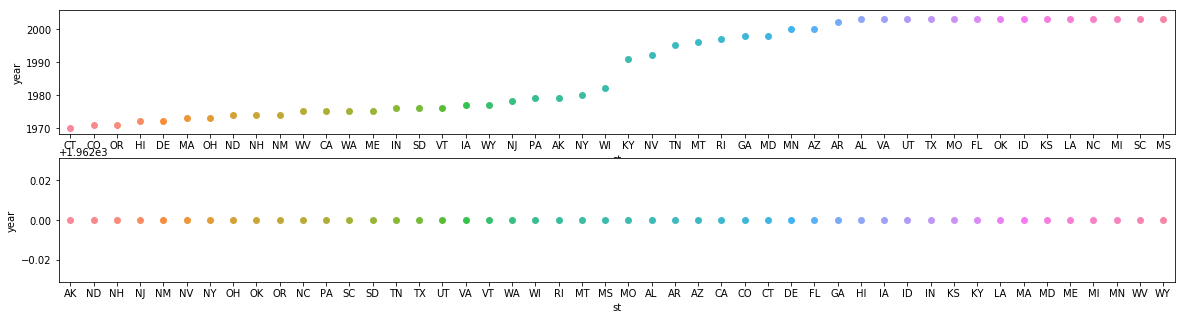

In [228]:
print "\n|  The dataset is now ready to be used.  Care still has to be taken to ensure"
print "|  that columns are interpreted as they are presented. To reuse the example given"
print "|  earlier (lifting of sodomy bans), we wouldn't want to get the plot on the "
print "|  bottom when we really want is the plot on the top, as one is a mere artifact "
print "|  of how this one column of data is stored while the other is a real policy story.\n"

fig, axs = plt.subplots(2,1, figsize=(20,5))

table = policy_table('gayrights_ban_sodomy', 'adoption')
sns.stripplot(x='st', y='year', size=7, data=table, ax=axs[1])

table = policy_table('gayrights_ban_sodomy', 'repeal')
sns.stripplot(x='st', y='year', size=7, data=table, ax=axs[0])